In [1]:
#import useful libraries for analysis and modeling
import pandas as pd
import numpy as np
from sklearn import tree
from scipy import stats
import os
import pickle
import sys
import tempfile
import math
# import matplotlib as mpl
# import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.tree import export_graphviz, DecisionTreeClassifier
pd.options.mode.chained_assignment = None
from IPython.display import display, HTML
import warnings
import json
from matplotlib import cm  # color map
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import copy as cp
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, DistanceMetric
from sklearn.preprocessing import scale
from sklearn.datasets import load_iris, load_wine
from matplotlib import pyplot as plt
import colorcet as cc
from sklearn.covariance import EllipticEnvelope 
#
from sklearn.cluster import OPTICS
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN
from sklearn.cluster import AgglomerativeClustering
import gower
from scipy.spatial.distance import hamming

# Filter all warnings
warnings.filterwarnings("ignore")


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# # list of 8 applications in dataset
# classes = ['Dropcam', 'HP Printer', 'Netatmo Welcome', 'Withings Smart Baby Monitor', 'Netatmo weather station',\
#            'Smart Things', 'Amazon Echo', 'Samsung SmartCam','TP-Link Day Night Cloud camera', 'Triby Speaker',\
#               'Belkin Wemo switch', 'TP-Link Smart plug', 'PIX-STAR Photo-frame','Belkin wemo motion sensor',\
#                      'Samsung Galaxy Tab', 'NEST Protect smoke alarm', 'Withings Smart scale', 'IPhone',\
#                             'MacBook', 'Withings Aura smart sleep sensor','Light Bulbs LiFX Smart Bulb',\
#                             'Blipcare Blood Pressure meter','iHome', 'Insteon Camera', 'Android Phone', 'Laptop']
# classes_df = pd.DataFrame(classes, columns=['class'])


# list of all extracted features
# feats_all = ["ip.len","ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst",\
#             "tcp.flags.ece","ip.proto","srcport","dstport","ip.hdr_len","tcp.window_size_value","tcp.hdr_len","udp.length",\
#             "Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Total","UDP Len Min","UDP Len Max",\
#                 "Flow IAT Min","Flow IAT Max","Flow IAT Mean","Flow Duration",\
#                     "SYN Flag Count","ACK Flag Count","PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count"]

# list of easy to compute online features - without means
feats_easy = ["ip.len","ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst",\
            "tcp.flags.ece","ip.proto","srcport","dstport","ip.hdr_len","tcp.window_size_value","tcp.hdr_len","udp.length",\
            "Min Packet Length","Max Packet Length","Packet Length Total","UDP Len Min","UDP Len Max",\
                "Flow IAT Min","Flow IAT Max","Flow Duration","SYN Flag Count","ACK Flag Count",\
                    "PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count"]

feats_all = ["ip.len","ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst",\
            "tcp.flags.ece","ip.proto","srcport","dstport","tcp.window_size_value","tcp.hdr_len","udp.length",\
            "Min Packet Length","Max Packet Length","Packet Length Total",\
                "SYN Flag Count","ACK Flag Count","PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count"]

In [3]:
def convert_str_to_dict(field_value):
    return json.loads(field_value.replace("\'", "\""))

""" Function to save trained model to pickle"""
def save_model(RF, filename):
    pickle.dump(RF, open(filename, 'wb'))

def get_test_labels(IoT_Test, classes, classes_df):
    array_of_indices = []
    unique_labels = IoT_Test["Label_NEW"].unique()
    # unique_labels = IoT_Test["Label"].unique()
    for lab in unique_labels:
        index = classes_df[classes_df['class'] == lab].index.values[0]
        array_of_indices.append(index)
    return unique_labels, array_of_indices

"""
Function to Fit model based on optimal values of depth and number of estimators and use it
to compute feature importance for all the features.
"""
def get_feature_importance(depth, n_tree, max_leaf, X_train, y_train, weight_of_samples,columns):
    
    # rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree, max_leaf_nodes=max_leaf, random_state=42, bootstrap=False,n_jobs=10)
    rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree, random_state=42, bootstrap=False,n_jobs=10)
    rf_opt.fit(X_train, y_train, sample_weight=weight_of_samples)
    feature_importance = pd.DataFrame(rf_opt.feature_importances_)
    # feature_importance.index = X_train.columns
    feature_importance.index = columns
    feature_importance = feature_importance.sort_values(by=list(feature_importance.columns),axis=0,ascending=False)
    
    return feature_importance

"""
Function to Fit model based on optimal values of depth and number of estimators and feature importance
to find the fewest possible features to exceed the previously attained score with all selected features
"""
def get_fewest_features(depth, n_tree, max_leaf, importance):    
    sorted_feature_names = importance.index
    # print('sorted_feature_names: ', sorted_feature_names)
    features = []
    for f in range(1,len(sorted_feature_names)+1):
        features.append(sorted_feature_names[0:f])
    return features

def get_result_scores(classes, cl_report):
    precision=[]
    recall=[]
    f1_score=[]
    supports=[]
    for a_class in classes:
        precision.append(cl_report[a_class]['precision'])
        recall.append(cl_report[a_class]['recall'])
        f1_score.append(cl_report[a_class]['f1-score'])
        supports.append(cl_report[a_class]['support'])
    return precision, recall, f1_score, supports

"""
Function to calculate the score of the model
"""
def get_scores(classes, depth, n_tree, feats, max_leaf, X_train, y_train, X_test, y_test, unique_labels,array_of_indices,weight_of_samples):
    # model = RandomForestClassifier(max_depth=depth, n_estimators = n_tree, max_leaf_nodes=max_leaf, n_jobs=10,
    #                                 random_state=42, bootstrap=False)
    
    model = RandomForestClassifier(n_estimators = n_tree, max_leaf_nodes=max_leaf, n_jobs=10,
                                    random_state=42, bootstrap=False)
    
    
    print(model)
    
    model.fit(X_train[feats], y_train, sample_weight=weight_of_samples)
    y_pred = model.predict(X_test[feats])

    y_test = [int(label) for label in y_test.values]
    y_pred = [int(label) for label in y_pred]

    class_report = classification_report(y_test, y_pred, labels=unique_labels, target_names=array_of_indices, output_dict = True)

    macro_score = class_report['macro avg']['f1-score']
    weighted_score = class_report['weighted avg']['f1-score']

    return model, class_report, macro_score, weighted_score, y_pred


def get_x_y_flow(Dataset, feats, classes):    
    X = Dataset[feats]
    y = Dataset['Label_NEW'].replace(classes, range(len(classes)))
    y_all = Dataset['Label']
    sample_nature = Dataset['sample_nature']
    return X, y, sample_nature, y_all

def get_x_y_flow_binary(Dataset, feats, classes):    
    X = Dataset[feats]
    y = Dataset['Label_Binary'].replace(classes, range(len(classes)))
    sample_nature = Dataset['sample_nature']
    return X, y, sample_nature

"""
Function to calculate the score of the model in terms of Flow-Level metric
"""

def expand_rows_and_get_scores(y_true, y_pred, y_test_ALL, sample_nature, multiply, test_flow_pkt_cnt, test_flow_IDs, unique_labels, array_of_indices):
    expanded_y_true = []
    expanded_y_pred = []
    expanded_y_true_all = []
    #
    expanded_weights = []
    expanded_flow_IDs = []
    
    for true_label, pred_label, y_test_ALL_label, nature, mult, pkt_cnt, f_id in zip(y_true, y_pred, y_test_ALL, sample_nature, multiply, test_flow_pkt_cnt, test_flow_IDs):
        if nature == 'flw':
            expanded_y_true.extend([true_label] * (mult+1))
            expanded_y_pred.extend([pred_label] * (mult+1))
            expanded_y_true_all.extend([y_test_ALL_label] * (mult+1))
            #
            expanded_weights.extend([1/pkt_cnt] * (mult+1))
            expanded_flow_IDs.extend([f_id]* (mult+1))
        else:
            expanded_y_true.append(true_label)
            expanded_y_pred.append(pred_label)
            expanded_y_true_all.append(y_test_ALL_label)
            #
            expanded_weights.append(1/pkt_cnt)
            expanded_flow_IDs.append(f_id)
    
    # report = classification_report(expanded_y_true, expanded_y_pred)
    
    num_samples = len(expanded_y_true)

    expanded_y_true = [int(label) for label in expanded_y_true]
    expanded_y_pred = [int(label) for label in expanded_y_pred]
    # labels=array_of_indices, target_names=unique_labels,
    cl_report_PL = classification_report(expanded_y_true, expanded_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)
    macro_f1_PL = cl_report_PL['macro avg']['f1-score']
    weighted_f1_PL = cl_report_PL['weighted avg']['f1-score']
    try:
        micro_f1_PL = cl_report_PL['micro avg']['f1-score']
    except:
        micro_f1_PL = cl_report_PL['accuracy']
    ####
    
    c_report_FL =  classification_report(expanded_y_true, expanded_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True,sample_weight=expanded_weights)
    
    macro_f1_FL = c_report_FL['macro avg']['f1-score']
    weighted_f1_FL = c_report_FL['weighted avg']['f1-score']
    try:
        micro_f1_FL = c_report_FL['micro avg']['f1-score']
    except:
        micro_f1_FL = c_report_FL['accuracy']
    
    return num_samples, macro_f1_PL, weighted_f1_PL, micro_f1_PL, cl_report_PL, macro_f1_FL, weighted_f1_FL, micro_f1_FL, c_report_FL, expanded_y_true, expanded_y_pred, expanded_weights, expanded_y_true_all

def compute_flow_pkt_scores(y_pred, y_test, sample_nature,unique_labels,array_of_indices):

    # Create a data frame with the three columns
    df = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test, 'sample_nature': sample_nature})
    
    # Split the data frame into two data frames based on sample_nature
    pkt_df = df[df['sample_nature'] == 'pkt']
    flw_df = df[df['sample_nature'] == 'flw']
    
    # Compute macro and weighted F1 scores for pkt_df
    pkt_df_y_true = [int(label) for label in pkt_df['y_test'].values]
    pkt_df_y_pred = [int(label) for label in pkt_df['y_pred']]

    # labels=array_of_indices, target_names=unique_labels,
    pkt_macro_f1 = classification_report(pkt_df_y_true, pkt_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['macro avg']['f1-score']
    pkt_weighted_f1 = classification_report(pkt_df_y_true, pkt_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['weighted avg']['f1-score']
    
    # Compute macro and weighted F1 scores for flw_df
    flw_df_y_true = [int(label) for label in flw_df['y_test'].values]
    flw_df_y_pred = [int(label) for label in flw_df['y_pred']]

    flw_macro_f1 = classification_report(flw_df_y_true, flw_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['macro avg']['f1-score']
    flw_weighted_f1 = classification_report(flw_df_y_true, flw_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['weighted avg']['f1-score']

    return pkt_macro_f1, pkt_weighted_f1, flw_macro_f1, flw_weighted_f1

In [4]:
# Define a function to check the conditions and assign values
def assign_sample_nature(row):
    if (row["Min Packet Length"] == -1 and
        row["Max Packet Length"] == -1 and
        row["Flow IAT Min"] == -1 and
        row["Flow IAT Max"] == -1):
        return "pkt"
    else:
        return "flw"

In [5]:
def read_csv(csv_file_names):
    csv_files = []
    for f_name in csv_file_names:
        df = pd.read_csv(f_name, sep=';')
        csv_files.append(df)
        
    return pd.concat(csv_files)

In [6]:
def plot_line(x_axis_values, y_axis_values, labels, x_title, y_title, fig_title):
    fig = plt.figure(figsize = (15, 5))
    colors= {'#6E7E99', '#ffbb78','#8A9961','#1f77b4', '#E06B5A', '#A95C68'}
    # for x_axis_val, y_axis_val, label, color in zip(x_axis_values, y_axis_values, labels, colors):
    #     plt.plot(x_axis_val, y_axis_val, label=label, color=color, linewidth=1.5)
    
    for x_axis_val, y_axis_val, color in zip(x_axis_values, y_axis_values, colors):
        plt.plot(x_axis_val, y_axis_val, 'g*-', color=color, linewidth=1.5, markersize=4)
    plt.plot(x_axis_val, [0.7 for i in range(0, len(x_axis_val))], color='gray', linestyle='--', lw=1)
    plt.plot(x_axis_val, [0.5 for i in range(0, len(x_axis_val))], color='gray', linestyle='--', lw=1)
    plt.xlabel(x_title, fontsize=15, labelpad=13)
    plt.ylabel(y_title, fontsize=15, labelpad=14)
    plt.xticks(rotation=90)
    plt.title(fig_title)
    plt.legend()
    plt.show()

In [7]:
def analyze_model(npkts, depth, n_tree, max_leaves, feats, classes, classes_df):    

    # Load Train and Test data
    train_data = pd.read_csv("/home/nds-admin/ToN-IoT/data/train/train_"+str(npkts)+"_pkts.csv")
    test_data = pd.read_csv("/home/nds-admin/ToN-IoT/data/test/test_"+str(npkts)+"_pkts.csv")
    #
    flow_pkt_counts = pd.read_csv("/home/nds-admin/ToN-IoT/ToN_IoT_Test_Flow_PktCounts.csv")
    flow_pkt_counts_train = pd.read_csv("/home/nds-admin/ToN-IoT/ToN_IoT_Train_Flow_PktCounts.csv")

    flow_count_dict_train = flow_pkt_counts_train.set_index("Flow ID")["packet_counts"].to_dict()
    train_data["pkt_count"] = train_data["Flow ID"].map(flow_count_dict_train)

    # # Extract the count column values and assign them to the pkt_count column in test_data
    flow_count_dict = flow_pkt_counts.set_index("Flow ID")["packet_counts"].to_dict()
    test_data["pkt_count"] = test_data["Flow ID"].map(flow_count_dict)
    #
    all_minus_one = (test_data['Min Packet Length'] == -1) & (test_data['Max Packet Length'] == -1) & (test_data['Packet Length Mean'] == -1)
    # Assign values to the multiply column based on the conditions
    test_data['multiply'] = np.where(all_minus_one, 1, test_data['pkt_count'] - npkts)

    train_data = train_data.sample(frac=1, random_state=42)
    test_data  = test_data.sample(frac=1, random_state=42)

    train_data = train_data.dropna(subset=['srcport', 'dstport']) 
    test_data  = test_data.dropna(subset=['srcport', 'dstport'])

    
    # train_data = train_data[~train_data['Label'].isin(classes)]
    # test_data = test_data[~test_data['Label'].isin(classes)]
    
    ####
    train_data['Label_NEW'] = np.where((train_data['Label'].isin(classes)), train_data['Label'], 'Other')
    test_data['Label_NEW'] = np.where((test_data['Label'].isin(classes)), test_data['Label'], 'Other')
    # print(train_data['Label_NEW'].value_counts())
    # print(test_data['Label_NEW'].value_counts())
    ####

    test_labels, test_indices = get_test_labels(test_data, classes, classes_df)
    print("Num Labels: ", len(test_labels))
    # print("Index: ", test_indices)

    train_data['sample_nature'] = train_data.apply(assign_sample_nature, axis=1)
    test_data['sample_nature']  = test_data.apply(assign_sample_nature, axis=1)
    
    # train_data['weight'] = np.where(train_data['sample_nature'] == 'flw', npkts, 1)
    # weight_of_samples = list(train_data['weight'])
    
    train_data['weight'] = np.where(train_data['sample_nature'] == 'flw', (train_data['pkt_count'] - npkts + 1)/train_data['pkt_count'], 1/train_data['pkt_count'])
    weight_of_samples = list(train_data['weight'])

    # Get Variables and Labels
    y_multiply = test_data['multiply'].astype(int)
    test_flow_pkt_cnt = test_data['pkt_count'].to_list()
    test_flow_IDs = test_data['Flow ID'].to_list()
    X_train, y_train, sample_nat_train, y_train_ALL = get_x_y_flow(train_data, feats, classes)
    X_test,  y_test, sample_nat_test, y_test_ALL  = get_x_y_flow(test_data, feats, classes)
    
    
    model, c_report, macro_f1, weight_f1, y_pred = get_scores(classes, depth, n_tree, feats, max_leaves, X_train, y_train, X_test, y_test,  test_indices, test_labels, weight_of_samples)
    #
    pkt_macro_f1, pkt_weighted_f1, flw_macro_f1, flw_weighted_f1 = compute_flow_pkt_scores(y_pred, y_test, sample_nat_test, test_indices, test_labels)
    #
    num_samples, macro_f1_PL, weighted_f1_PL, micro_f1_PL, cl_report_PL, macro_f1_FL, weighted_f1_FL, micro_f1_FL, cl_report_FL, expanded_y_true, expanded_y_pred, expanded_weights, expanded_y_true_all = expand_rows_and_get_scores(y_test, y_pred, y_test_ALL, sample_nat_test, y_multiply, test_flow_pkt_cnt, test_flow_IDs, test_indices, test_labels)
                           
    print(macro_f1_FL, weighted_f1_FL, micro_f1_FL)
    return cl_report_FL, expanded_y_true, expanded_y_pred, expanded_weights, expanded_y_true_all
    

In [8]:
clusters_best_model_info = pd.read_csv('/home/nds-admin/distributed_in_band/ToN-IoT/cluster_info/Best_models_perCluster_with_others_6CL.csv')

In [9]:
cluster_list = []
all_classes_in_clusters = []
cluster_info_all_classes = []
cluster_no = 0
for cl in clusters_best_model_info['Class List'].to_list():
    classes_str = cl[2:-2] 
    classes = classes_str.split("', '")
    cluster_list.append(classes)
    all_classes_in_clusters.extend(classes)
    cluster_info_all_classes.extend([cluster_no]*len(classes))
    cluster_no = cluster_no + 1
print(all_classes_in_clusters)
print(cluster_info_all_classes)


['dos', 'backdoor', 'xss', 'ddos', 'scanning', 'injection', 'password', 'mitm', 'ransomware', 'normal']
[0, 0, 1, 1, 2, 3, 3, 4, 4, 5]


#### Run to obtain Confusion Matrix

In [16]:
cm_matrix = pd.DataFrame()
cm_matrix['Classes'] = [i for i in all_classes_in_clusters]
cm_matrix_cluster = pd.DataFrame()
cm_matrix_cluster['Clusters'] = [i for i in range(0, len(cluster_list))]
##
for i in range(0, len(cluster_list)):
    npkts = int(clusters_best_model_info.loc[i]['N_With_Others'])
    n_tree = int(clusters_best_model_info.loc[i]['Tree_With_Others'])
    # depth = int(clusters_best_model_info.loc[i]['Depth_With_Others'])
    depth=10
    max_n_leaves = int(clusters_best_model_info.loc[i]['N_Leaves_With_Others'])
    #
    feat_names_str = clusters_best_model_info.loc[i]['Feats_Names_With_Others']
    feat_names_str = feat_names_str[2:-2] 
    feat_names = feat_names_str.split("', '")
    print(npkts, n_tree, len(feat_names), max_n_leaves)
    #
    classes = cluster_list[i]
    total_classes = len(classes)
    classes.append('Other')
    classes_df = pd.DataFrame(classes, columns=['class'])
    #
    cluster_perf_dict = {}
    for cl in cm_matrix_cluster['Clusters'].to_list():
        cluster_perf_dict[cl] = 0
    #
    ####
    #
    cl_report, expanded_y_true, expanded_y_pred, expanded_weights, expanded_y_true_all = analyze_model(npkts, depth, n_tree, max_n_leaves, feat_names, classes, classes_df)
    #
    pred_df = pd.DataFrame()
    pred_df['True_Label_Cluster'] = expanded_y_true
    pred_df['Pred_Label_Cluster'] = expanded_y_pred
    pred_df['True_Label_All'] = expanded_y_true_all
    pred_df['Weight_per_packet'] = expanded_weights
    #
    # performance_dict = {}
    for cla_in_clu in classes[:-1]:
        performance_vals = []
        cla_in_clu_ind = classes.index(cla_in_clu)
        for cla in all_classes_in_clusters:
            if cla in classes:
                cla_ind = classes.index(cla)
                metric_val = sum(pred_df[((pred_df['True_Label_Cluster'] == cla_ind) & (pred_df['Pred_Label_Cluster'] == cla_in_clu_ind))]['Weight_per_packet'].to_list())
                performance_vals.append(metric_val)
                #
                cluster_perf_dict[i] = cluster_perf_dict[i] + metric_val
            else:
                cla_ind = all_classes_in_clusters.index(cla)
                cluster_of_cls = cluster_info_all_classes[cla_ind]
                metric_val = sum(pred_df[((pred_df['True_Label_All'] == cla) & (pred_df['Pred_Label_Cluster'] == cla_in_clu_ind))]['Weight_per_packet'].to_list())
                performance_vals.append(metric_val)
                cluster_perf_dict[cluster_of_cls] = cluster_perf_dict[cluster_of_cls] + metric_val
        cm_matrix_cluster[str(i)] = cluster_perf_dict.values()
        cm_matrix[cla_in_clu] = performance_vals

    

In [14]:
print(all_classes_in_clusters)

['dos', 'backdoor', 'xss', 'ddos', 'scanning', 'injection', 'password', 'mitm', 'ransomware', 'normal']


In [10]:
# cm_matrix.to_csv('CM_matrix_all_classes_after_clustering_6CL.csv')
# cm_matrix_cluster.to_csv('CM_matrix_Cluster_after_clustering_6CL.csv')

#### Run to obtain Confusion Matrix from the saved files

In [11]:
cm_matrix = pd.read_csv('CM_matrix_all_classes_after_clustering_6CL.csv', sep=',')
cm_matrix_cluster = pd.read_csv('CM_matrix_Cluster_after_clustering_6CL.csv', sep=',')
# avg_score_difference_per_cluster = pd.read_csv('Score_change_per_cluster_wot_others.csv', sep=',')

#### ---

In [20]:
#######
## Dataframe ##
cm_matrix_cluster_normalized_df = pd.DataFrame()
cm_matrix_cluster_normalized_df['Clusters'] = cm_matrix_cluster['Clusters'].to_list()

cm_matrix_cluster['sum'] = cm_matrix_cluster['0'] + cm_matrix_cluster['1'] + cm_matrix_cluster['2'] + cm_matrix_cluster['3']
for i in range(0, len(cm_matrix_cluster['Clusters'].to_list())):
    cm_matrix_cluster_normalized_df[str(i)] = (cm_matrix_cluster[str(i)]*100)/sum(cm_matrix_cluster[str(i)].to_list())
cm_matrix_cluster_normalized_df

,Clusters,0,1,2,3,4,5
0,0,0.044850,0.044850,0.044850,0.044850,0.044850,0.044850
1,1,56.581395,56.581395,56.581395,56.581395,56.581395,56.581395
2,2,2.933555,2.933555,2.933555,2.933555,2.933555,2.933555
3,3,25.428571,25.428571,25.428571,25.428571,25.428571,25.428571
4,4,0.652824,0.652824,0.652824,0.652824,0.652824,0.652824
5,5,14.358804,14.358804,14.358804,14.358804,14.358804,14.358804


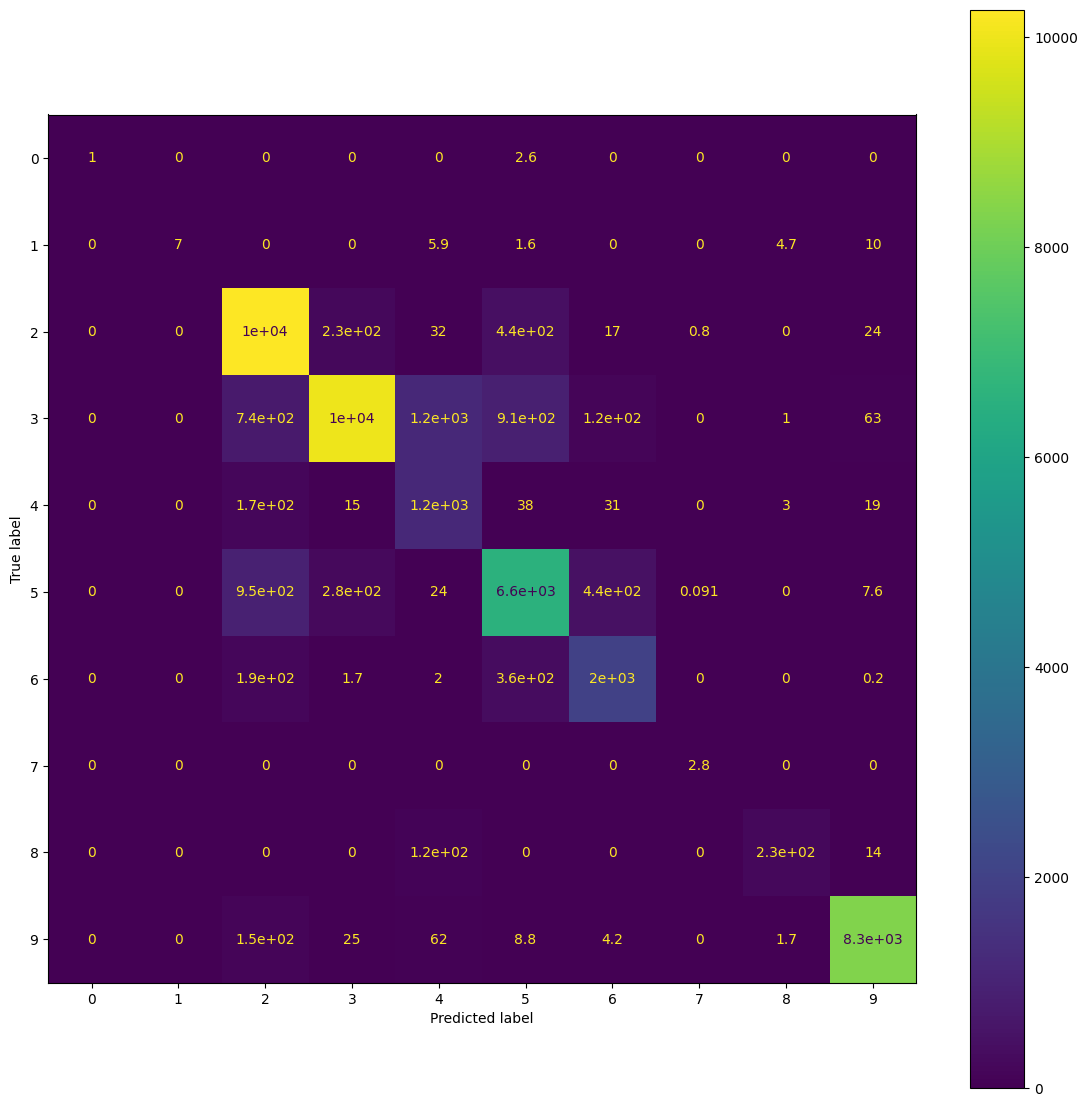

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# cm = confusion_matrix(y_true=list(y_test), y_pred=y_pred, labels=list(range(0, len(classes))))
# cm = cm_matrix_cluster_normalized_df[['0', '1', '2', '3', '4', '5']].to_numpy()
cm = cm_matrix[cm_matrix.columns[2:].to_list()].to_numpy()
#
# cm_normalized = []
# for cl_list in cm:
#     if np.sum(cl_list)!=0:
#         cm_normalized.append(np.array(cl_list)*100/np.sum(cl_list))
#     else:
#         cm_normalized.append(np.array(cl_list))
# cm_normalized = np.array(cm_normalized)
# cm_normalized
#
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(14,14))
disp.plot(ax=ax)
# ax.set_xticklabels(['CL0', 'CL1', 'CL2', 'CL3', 'CL5', 'CL6', 'CL7'], rotation=90)

In [ ]:
cost_FP = cm_matrix_cluster_normalized_df[['0', '1', '2', '3', '4', '5']].to_numpy()
cost_F1 = clusters_best_model_info['Macro_f1_FL_With_Others'].to_list()
# score_change = avg_score_difference_per_cluster['Avg_F1_score_change'].to_list()
# support_values = avg_score_difference_per_cluster['Support'].to_list()

#### Optimization

In [28]:
## Solver: Gurobi
## Language: Python (written in Pyomo)
## Written by: @setyotw (inspired from http://www.opl.ufc.br/post/tsp/)
## Date: September 1st, 2022

#%% import packages
import pyomo.environ as pyo
import numpy as np
import gurobipy 

#%%%%%%%%%%%%%%%%%%%%%%%%%%
#  DEVELOPMENT PARTS
# def TSP_MTZ_Formulation(n, costMatrix_FP, cost_F1, score_change, support_values):
def TSP_MTZ_Formulation(n, costMatrix_FP, cost_F1):
    #%
    # 1 | initialize sets and notations
    N = [i for i in range(1,n+1)]
    arc_IJ = [(i,j) for i in N for j in N if i!=j]
    cost_FP = {(i,j) : costMatrix_FP[i-1][j-1] for (i,j) in arc_IJ}
    cost_F1 = {(i) : cost_F1[i-1]/100 for i in range(1,n+1)}
    # score_change = {(i) : score_change[i-1]/100 for i in range(1,n+1)}
    # support_values = {(i) : support_values[i-1] for i in range(1,n+1)}

    print(cost_FP)
    print(cost_F1)
    
    # 2 | initialize the model
    model = pyo.ConcreteModel()

    # 3 | initialize decision variables
    model.x = pyo.Var(arc_IJ, within=pyo.Binary)
    model.u = pyo.Var(N, within=pyo.NonNegativeIntegers,bounds=(0,n-1))

    # 4 | define objective function
    model.objective = pyo.Objective(
        # expr= sum(model.x[i,j]*cost_FP[j,i]*cost_F1[i] for (i,j) in arc_IJ),
        expr= sum(model.x[i,j]*cost_FP[j,i]*(1-cost_F1[i]) for (i,j) in arc_IJ),
        sense=pyo.minimize)
        # sense=pyo.maximize)

    # 5 | define constraints
    model.constraints = pyo.ConstraintList()
    

    for i in N:
        for j in N:
            if i!=j:
                model.constraints.add(model.x[i,j] + model.x[j,i] == 1)

    # a) each node is visited only once (restrict the inbound arc to 1)
    # for j in N:
    #     model.constraints.add(sum([model.x[i,j] for i in N if i!=j]) == 1)

    # b) each node is visited only once (restrict the outbound arc to 1)
    # for i in N:
    #     model.constraints.add(sum([model.x[i,j] for j in N if i!=j]) == 1)

    # c) subtour elimination constraints
    for i in N:
        for j in N:
            # if i!=j and i>1 and j>1:
            if i!=j:
                model.constraints.add(model.u[i] - model.u[j] + model.x[i,j] * n <= n-1)

    # # 6 | call the solver (we use Gurobi here, but you can use other solvers i.e. PuLP or CPLEX)
    model.pprint()
    solver = pyo.SolverFactory('gurobi')
    completeResults = solver.solve(model,tee = True)

    # # 7 | extract the results
    solutionObjective = model.objective()
    tourRepo = []
    for i in model.x:
        if model.x[i].value > 0:
            tourRepo.append((i, model.x[i].value))
            cluster_pair = str(model.x[i])[2:-1].split(sep=',')
            cluster_pair[0] = int(cluster_pair[0])
            cluster_pair[1] = int(cluster_pair[1])
            # print(str(model.x[i]), model.x[i].value, cost_FP[(cluster_pair[1], cluster_pair[0])]*cost_F1[cluster_pair[0]])
            print(str(model.x[i]), model.x[i].value, cost_FP[(cluster_pair[1], cluster_pair[0])],cost_F1[cluster_pair[0]])
    solutionGap = (completeResults.Problem._list[0]['Upper bound'] - completeResults.Problem._list[0]['Lower bound']) / completeResults.Problem._list[0]['Upper bound']
    runtimeCount = completeResults.Solver._list[0]['Time']

    return solutionObjective, solutionGap, tourRepo, runtimeCount, completeResults




In [29]:
solutionObjective, solutionGap, tourRepo, runtimeCount, completeResults = TSP_MTZ_Formulation(6, cost_FP, cost_F1)

{(1, 2): 0.0, (1, 3): 0.2275353750924759, (1, 4): 0.03852433359385319, (1, 5): 1.8848974947498347, (1, 6): 0.11844274015039276, (2, 1): 0.0, (2, 3): 46.87705142968346, (2, 4): 13.57886046140927, (2, 5): 0.727241631737224, (2, 6): 1.030564641918093, (3, 1): 0.0, (3, 2): 0.8139005155494352, (3, 4): 0.6268048220641979, (3, 5): 1.2120693862287073, (3, 6): 0.22504120628574867, (4, 1): 0.0, (4, 2): 6.17759156192015, (4, 3): 0.9901534220696152, (4, 5): 0.03672937534026384, (4, 6): 0.0920563297057784, (5, 1): 0.0, (5, 2): 0.0, (5, 3): 4.465766105593826, (5, 4): 0.0, (5, 6): 0.1658198362105616, (6, 1): 0.0, (6, 2): 0.7782901150124804, (6, 3): 2.376079174593283, (6, 4): 0.11893339839733513, (6, 5): 0.6733718812381705}
{1: 0.622169604490047, 2: 0.729913969200496, 3: 0.7596550333850461, 4: 0.735896940523952, 5: 0.8242578835971855, 6: 0.983744835451516}
2 Var Declarations
    u : Size=6, Index={1, 2, 3, 4, 5, 6}
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :  Non

In [27]:
import itertools

# The given number set
number_set = (0, 1, 2, 3, 4, 5)

# Generating all possible permutations
all_permutations = list(itertools.permutations(number_set))
all_obj = []
# Printing all permutations
print("All permutations: ", len(all_permutations))
for perm in all_permutations:
    # print(perm)
    obj = 0
    for i in range(0, len(perm)):
        cum_FP = 0
        for j in range(i+1, len(perm)):
        # if i < 7:
            # obj = obj + cost_FP[perm[i+1], perm[i]]
            # obj = obj + (cost_F1[perm[i]]/100)*(cost_FP[perm[i+1], perm[i]])*(score_change[perm[i+1]]/100)
            cum_FP = cum_FP + (1-cost_F1[perm[i]]/100)*(cost_FP[perm[j], perm[i]])
        obj = obj + cum_FP
    # print(obj)
    all_obj.append(obj)
opt_value = min(all_obj)
count = 0
for opt in all_obj:
    if opt == opt_value:
        print('MIN: ', opt_value, all_permutations[count])
    count = count + 1
opt_value_ind = all_obj.index(opt_value)
print(len(all_obj))
print('MIN: ', min(all_obj), all_permutations[opt_value_ind])

All permutations:  720
MIN:  2.291458954115021 (0, 5, 1, 3, 4, 2)
720
MIN:  2.291458954115021 (0, 5, 1, 3, 4, 2)
